In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import neurokit2 as nk
sns.set()

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

ModuleNotFoundError: No module named 'neurokit2'

# Data Processing

In [101]:
datafile = pd.read_csv('/home/artem/Electrocardiography/респираторные 200 по 3 минуты.csv')
X = pd.DataFrame()
Y = pd.DataFrame(columns = ['disease_diabetes', 'disease_ibs', 'respiratory_disease'])
for index in range(datafile.shape[0]):
    ecg = list()
    for string in datafile['data'][index].split(','):
                ecg.extend(float(s) for s in re.findall(r'[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?', string))
    ecg = np.array(ecg)

    try:
        _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=1000)
        RtoR = pd.DataFrame(data = ecg[rpeaks['ECG_R_Peaks'][15]:rpeaks['ECG_R_Peaks'][11]+1].reshape(1,-1))
    except:
        continue
    
    y = {'disease_diabetes': datafile['diseasediabetes'][index], 'disease_ibs': datafile['diseaseibs'][index],
                               'respiratory_disease': datafile['respiratory_disease'][index]}
    X = pd.concat([X, RtoR],ignore_index=True)
    Y = Y.append(y,ignore_index=True)
    
    pd.concat([X,Y], axis=1).fillna(0).to_csv("Чистая ЭКГ Респираторные 3 минуты.csv", sep=',', index=True, header=True)

/home/artem/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


(54946, 55780)

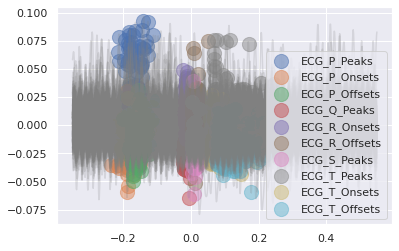

In [97]:
_, waves_dwt = nk.ecg_delineate(ecg, rpeaks, sampling_rate=1000, method="dwt", show=True, show_type='all')
waves_dwt['ECG_R_Onsets'][15], waves_dwt['ECG_R_Onsets'][16]

In [105]:
files = ['/home/artem/Electrocardiography/Чистая ЭКГ Диабет 1 минута.csv', '/home/artem/Electrocardiography/Чистая ЭКГ Здоровые 1 минута.csv',
        '/home/artem/Electrocardiography/Чистая ЭКГ Здоровые 3 минуты.csv', '/home/artem/Electrocardiography/Чистая ЭКГ ИБС 5 минут.csv',
        '/home/artem/Electrocardiography/Чистая ЭКГ сердечники 1 минута.csv']

combined = pd.DataFrame()

for file in files:
    data = pd.read_csv(file)
    data['filename'] = file
    combined = pd.concat([combined, data])
    
combined.to_csv('ECGs_from_R_to_R', sep=',', header=True, index=True)

# Actual working

In [2]:
data = pd.read_csv('/home/artem/Electrocardiography/ECGs_from_R_to_R')
data.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
data

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,0.191463,0.189820,0.185506,0.178886,0.170454,0.160722,0.150153,0.139140,0.128021,0.117088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.226212,0.225600,0.223168,0.219140,0.213738,0.207153,0.199526,0.190953,0.181511,0.171294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.137084,0.136513,0.134962,0.132671,0.129818,0.126477,0.122631,0.118215,0.113189,0.107587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.142761,0.142141,0.139806,0.135978,0.130925,0.124909,0.118164,0.110892,0.103277,0.095501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.171529,0.170472,0.167819,0.163570,0.157876,0.150999,0.143208,0.134676,0.125439,0.115443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,0.190422,0.188709,0.185390,0.180580,0.174307,0.166577,0.157474,0.147234,0.136260,0.125035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475,0.195578,0.194503,0.191994,0.188057,0.182695,0.175910,0.167727,0.158218,0.147533,0.135910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476,0.208499,0.206504,0.202573,0.196922,0.189830,0.181586,0.172454,0.162646,0.152335,0.141678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,0.187522,0.185868,0.182286,0.177016,0.170286,0.162294,0.153225,0.143295,0.132780,0.122013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data.fillna(value=0, inplace=True)

## Y creating

In [4]:
Y = data[['disease_diabetes', 'disease_ibs', 'respiratory_disease']]
y = pd.DataFrame()
for line in range(Y.shape[0]):
    disease = {'diseases': str([Y['disease_diabetes'][line], Y['disease_ibs'][line], Y['respiratory_disease'][line]])}
    y = y.append(disease, ignore_index=True)
y

,diseases
0,"[1, 0, 0]"
1,"[1, 0, 0]"
2,"[1, 0, 0]"
3,"[1, 0, 0]"
4,"[1, 0, 0]"
...,...
474,"[1, 1, 0]"
475,"[1, 1, 0]"
476,"[1, 1, 0]"
477,"[1, 1, 0]"


## X creating

In [5]:
X = data.drop(['disease_diabetes', 'disease_ibs', 'respiratory_disease', 'filename'], axis=1)
X

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,0.191463,0.189820,0.185506,0.178886,0.170454,0.160722,0.150153,0.139140,0.128021,0.117088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.226212,0.225600,0.223168,0.219140,0.213738,0.207153,0.199526,0.190953,0.181511,0.171294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.137084,0.136513,0.134962,0.132671,0.129818,0.126477,0.122631,0.118215,0.113189,0.107587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.142761,0.142141,0.139806,0.135978,0.130925,0.124909,0.118164,0.110892,0.103277,0.095501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.171529,0.170472,0.167819,0.163570,0.157876,0.150999,0.143208,0.134676,0.125439,0.115443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,0.190422,0.188709,0.185390,0.180580,0.174307,0.166577,0.157474,0.147234,0.136260,0.125035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475,0.195578,0.194503,0.191994,0.188057,0.182695,0.175910,0.167727,0.158218,0.147533,0.135910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476,0.208499,0.206504,0.202573,0.196922,0.189830,0.181586,0.172454,0.162646,0.152335,0.141678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,0.187522,0.185868,0.182286,0.177016,0.170286,0.162294,0.153225,0.143295,0.132780,0.122013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ML

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
X_train.shape, y_train.shape

((383, 1426), (383, 1))

In [7]:
labels = y_train['diseases'].unique()
y_train = y_train.to_numpy().ravel()
y_train.shape

(383,)

Cross Validation accuracy scores: [0.61538462 0.69230769 0.56410256 0.63157895 0.63157895 0.60526316
 0.57894737 0.63157895 0.63157895 0.60526316]
Cross Validation accuracy: 0.619 +/- 0.033
Best Parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 50, 'n_jobs': -1, 'warm_start': True}
Random Forest accuracy: 0.552
Random Forest f1-score: 0.47
              precision    recall  f1-score   support

   [0, 0, 0]       0.83      0.77      0.80        31
   [0, 1, 0]       0.67      0.77      0.71        26
   [1, 0, 0]       0.38      0.36      0.37        25
   [1, 1, 0]       0.00      0.00      0.00        14

    accuracy                           0.55        96
   macro avg       0.47      0.48      0.47        96
weighted avg       0.55      0.55      0.55        96



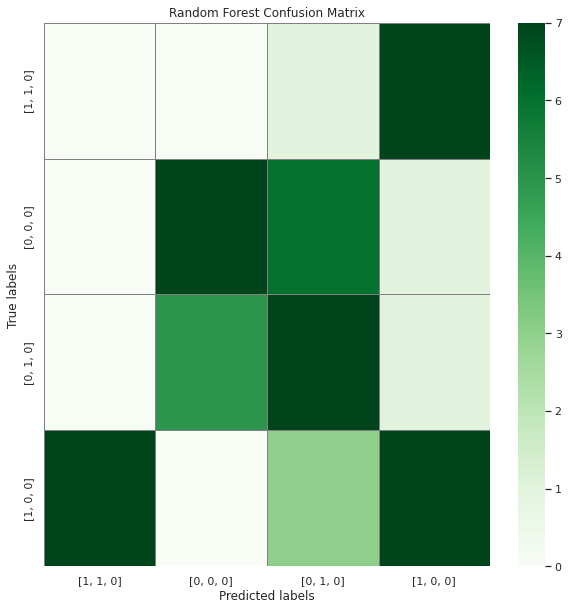

In [12]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False],
         'n_estimators': [50],
         'max_features': ['log2'],
         'min_samples_leaf': [2],
         'min_samples_split': [7],
                 'criterion' : ['entropy'],
                 'max_depth' : [30],
                 'n_jobs' : [-1], 'warm_start' : [True]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=10, scoring='accuracy')


kf = KFold(n_splits=10)
results = cross_val_score(rf_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),np.std(results)))
print('===================')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train)

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test, rf_pred), 3))
print('Random Forest f1-score:', round(f1_score(y_test, rf_pred, average='macro'), 3))
print(classification_report(y_test, rf_model_best.predict(X_test)))

cm_rf = confusion_matrix(y_test, rf_pred, labels=labels)

k = 7
cm_rf[cm_rf > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_rf,  ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey')

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Random Forest Confusion Matrix')

/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/home/artem/anaconda3/lib/python3.9/site-

Cross Validation accuracy scores: [0.515625   0.390625   0.48031496]
Cross Validation accuracy: 0.462 +/- 0.053
Best Parameters:
 {'var_smoothing': 1e-05}
Naive Bayes accuracy: 0.427
Naive Bayes macro f1-score: 0.32
              precision    recall  f1-score   support

   [0, 0, 0]       0.56      0.88      0.68        33
   [0, 1, 0]       1.00      0.05      0.09        21
   [1, 0, 0]       0.30      0.10      0.15        30
   [1, 1, 0]       0.24      0.67      0.36        12

    accuracy                           0.43        96
   macro avg       0.53      0.42      0.32        96
weighted avg       0.53      0.43      0.35        96



/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:453: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/home/artem/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/home/artem/anaconda3/lib/python3.9/site-pack

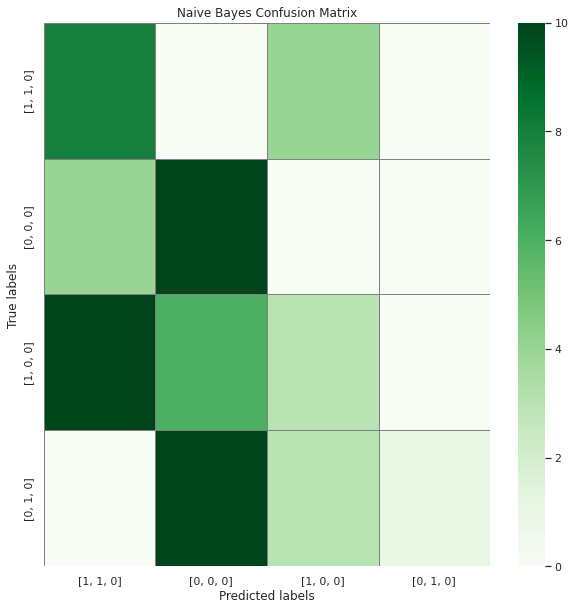

In [133]:
# Hyperparameters search grid 
nb_param_grid = {'var_smoothing': [1e-9, 1e-15, 1e-5, 0]}

# Instantiate naive bayes classifier
nb_estimator = GaussianNB()

# Create a Gaussian classifier
nb_model = GridSearchCV(estimator=nb_estimator, param_grid=nb_param_grid, cv=3, scoring='accuracy')


kf = KFold(n_splits=3)
results = cross_val_score(nb_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),
                                                    np.std(results)))
print('===================')

nb_model.fit(X_train, y_train)

print("Best Parameters:\n", nb_model.best_params_)

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test, nb_pred), 3))
print('Naive Bayes macro f1-score:', round(f1_score(y_test, nb_pred, average='macro'), 3))
print(classification_report(y_test, nb_model.predict(X_test)))

cm_nb = confusion_matrix(y_test, nb_pred, labels=labels)

k = 10
cm_nb[cm_nb > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_nb, ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey') 

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Naive Bayes Confusion Matrix')

In [ ]:
cat = CatBoostClassifier(silent=True)
params = {  
    "max_depth": [3, 7, 9],
    "learning_rate": [0.1, 0.25, 0.4, 0.5],
    "iterations": [25, 50, 75]
}

search_cat = GridSearchCV(estimator=cat, param_grid = params, n_jobs=-1)
kf = KFold(n_splits=3)
results = cross_val_score(search_cat, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),
                                                    np.std(results)))
print('===================')

search_cat.fit(X_train, y_train)
print(search_cat.best_params_)

print(classification_report(y_test, search_cat.best_estimator_.predict(X_test)))

Cross Validation accuracy scores: [0.64102564 0.69230769 0.66666667 0.68421053 0.57894737 0.68421053
 0.68421053 0.63157895 0.81578947 0.60526316]
Cross Validation accuracy: 0.668 +/- 0.061
Best Parameters:
 {'C': 3, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear', 'warm_start': True}
Logistic Regression accuracy: 0.646
Logistic Regression macro f1-score: 0.549
              precision    recall  f1-score   support

   [0, 0, 0]       0.69      0.81      0.75        31
   [0, 1, 0]       0.73      0.62      0.67        26
   [1, 0, 0]       0.57      0.80      0.67        25
   [1, 1, 0]       0.33      0.07      0.12        14

    accuracy                           0.65        96
   macro avg       0.58      0.57      0.55        96
weighted avg       0.62      0.65      0.61        96



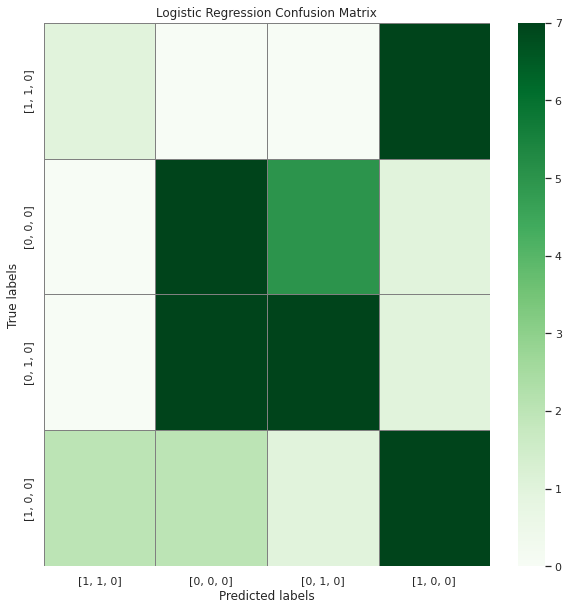

In [14]:
log_grid = {'C': [3], 
            'penalty': ['l1'],
            'solver' : ['liblinear'],
            'max_iter' : [50, 60, 70, 75, 80],
            'warm_start' : [True]
            }

log_estimator = LogisticRegression()

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

kf = KFold(n_splits=10)
results = cross_val_score(log_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results), 
                                                    np.std(results)))
print('===================')


log_model.fit(X_train, y_train)

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test, log_pred), 3))
print('Logistic Regression macro f1-score:', round(f1_score(y_test, log_pred, average='macro'), 3))
print(classification_report(y_test, best_log.predict(X_test)))

cm_log = confusion_matrix(y_test, log_pred, labels=labels)

k = 7
cm_log[cm_log > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_log, ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey') 

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Logistic Regression Confusion Matrix')

Cross Validation accuracy scores: [0.66666667 0.69230769 0.69230769 0.60526316 0.63157895 0.76315789
 0.73684211 0.65789474 0.78947368 0.68421053]
Cross Validation accuracy: 0.692 +/- 0.054
Best Parameters:
 {'C': 0.5, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'linear'}
SVM accuracy: 0.656
SVM macro f1-score: 0.557
              precision    recall  f1-score   support

   [0, 0, 0]       0.68      0.84      0.75        31
   [0, 1, 0]       0.76      0.62      0.68        26
   [1, 0, 0]       0.57      0.80      0.67        25
   [1, 1, 0]       0.50      0.07      0.12        14

    accuracy                           0.66        96
   macro avg       0.63      0.58      0.56        96
weighted avg       0.65      0.66      0.62        96



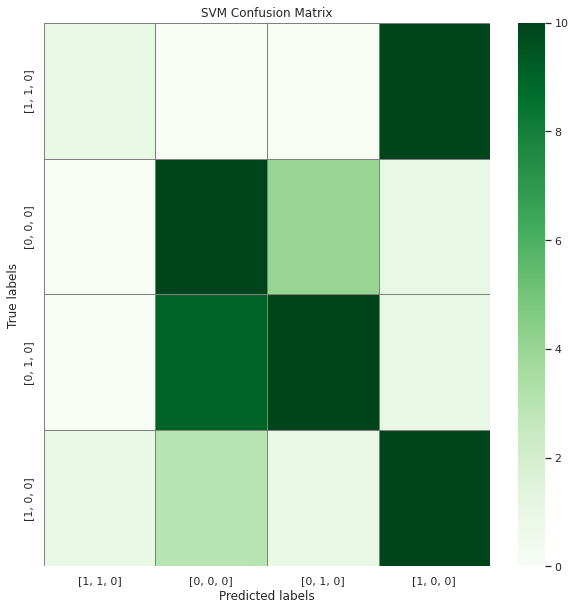

In [15]:
# Parameter grid
svm_param_grid = {'C': [0.1, 0.3, 0.5, 1], 
                  'gamma': ["auto"], 
                  "kernel": ["poly", "linear", "rbf"], 
                  "decision_function_shape" : ["ovo", "ovr"]
                  } 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

kf = KFold(n_splits=10)
results = cross_val_score(svm_grid, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),np.std(results)))
print('===================')


# Train the classifier
svm_grid.fit(X_train, y_train)

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test)

print('SVM accuracy:', round(accuracy_score(y_test, svm_pred), 3))
print('SVM macro f1-score:', round(f1_score(y_test, svm_pred, average='macro'), 3))

print(classification_report(y_test, best_svc.predict(X_test)))

cm_svm = confusion_matrix(y_test, svm_pred, labels=labels)

k = 10
cm_svm[cm_svm > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_svm,  ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey')

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('SVM Confusion Matrix')